# Visualizing the performance of the model during training

## Environment Setup and Module Initialization

The primary purpose of this code is to **configure the project environment** and **verify the availability of custom tools** needed for evaluation.

* **Dynamic Path Linking:** It adds the source directory (`../src`) to the system path so the notebook can access custom scripts located in different folders.
* **Dependency Verification:** It uses a `try-except` block to ensure that the required plotting utility (`plot_history`) is correctly accessible within the project's directory structure.
* **Visualization Readiness:** It initializes the environment for generating performance reports by importing essential libraries like `matplotlib`.

In [1]:
import sys
import os
import pickle
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

try:
    from utils.plot_results import plot_history
    print("Successfully imported 'plot_history' from src/utils/plot_results.py")
except ImportError as e:
    print(f"ImportError: {e}")
    print("Error: Could not import plot_history. Check your folder structure.")

Successfully imported 'plot_history' from src/utils/plot_results.py


# Phase One: Baseline Model

## Training History and Performance Analysis

This section focuses on the **Training and Validation** phase of your project. The code loads the saved training history file (`history.pkl`) and visualizes the learning progress using `matplotlib`.

### 1. Code Functionality: Loading and Plotting

The script acts as a diagnostic tool to evaluate how well the model learned over 30 epochs:

* **Data Retrieval:** It opens `history.pkl` using `pickle` to extract metrics like `accuracy`, `loss`, `val_accuracy`, and `val_loss`.
* **Visualization:** The `plot_history` function generates two side-by-side graphs: one for Accuracy and one for Loss, allowing you to compare training vs. validation performance.
* **Metric Confirmation:** The terminal output confirms that the model tracked `learning_rate` changes alongside standard metrics.

Loading training history from ../models/history.pkl...
History loaded successfully.
Metrics available: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']
Plotting results...


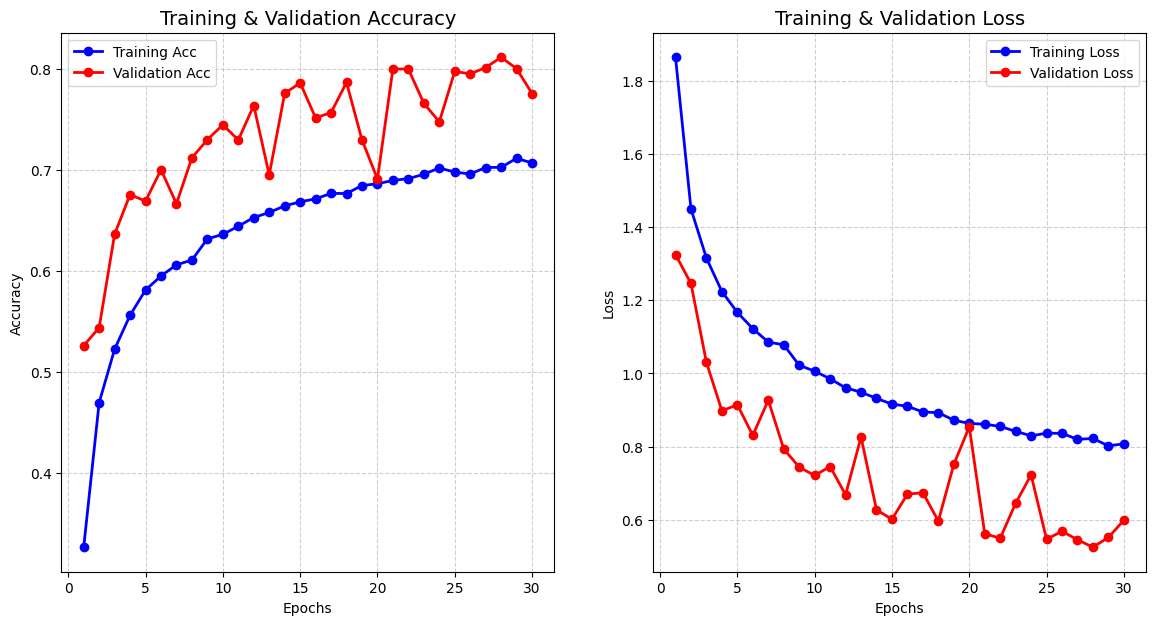


          BEST PERFORMANCE          
TRAINING:
  • Best Accuracy: 0.7111 (Epoch 29)
  • Lowest Loss:   0.8019 (Epoch 29)
----------------------------------------
VALIDATION:
  • Best Accuracy: 0.8112 (Epoch 28)
  • Lowest Loss:   0.5252 (Epoch 28)



In [2]:
history_path = '../models/history.pkl'

if os.path.exists(history_path):
    print(f"Loading training history from {history_path}...")
    
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    
    print("History loaded successfully.")
    print(f"Metrics available: {list(history.keys())}")
else:
    print(f"Error: File not found at {history_path}")

if 'history' in locals():
    print("Plotting results...")
    plot_history(history)
else:
    print("History data is not loaded yet.")

### 2. Performance Analysis: Best Results

Based on the terminal output above, the model reached its peak performance toward the end of the training session.

### 3. Why is Validation Accuracy higher than Training Accuracy?

It is rare but common in specific setups to see **Validation Accuracy (81.1%)** outperform **Training Accuracy (71.1%)**. Based on provided code, here are the three technical reasons why:

* **Heavy Use of Dropout:** Your `baseline_model.py` includes multiple `Dropout` layers with rates up to **0.5**.
    * **During Training:** Dropout randomly "turns off" 50% of neurons, making it harder for the model to get a high training score.
    * **During Validation:** All neurons are "on," making the model more robust and capable of achieving a higher score on the validation set.

* **Data Augmentation:** `data_loader.py` applies significant transformations (rotation, shifting, shearing, zooming) to the training data.
    * This makes the training set much "harder" to learn than the validation set, which is kept in its original, clean form.

* **Batch Normalization:** We have `BatchNormalization` after every Conv2D layer. This layer behaves differently during training (using batch statistics) vs. validation (using moving averages), which often leads to more stable and higher performance during validation.

### 4. Key Observations from the Graphs

* **Learning Stability:** The **Training Accuracy** (blue line) is very smooth, showing a steady learning process.

* **Validation Volatility:** The **Validation Accuracy** (red line) shows significant "spikes". This is likely due to the `ReduceLROnPlateau` callback in `train.py`, which drops the learning rate when progress stalls, causing the model to suddenly find better local minima.

* **No Overfitting:** Usually, overfitting occurs when Training Accuracy is much higher than Validation. Since your Validation score is higher, model is **generalizing exceptionally well** and is not just memorizing the training data.

# Phase Two: Final Model

## Final Model Architecture and Parameter Analysis

This section presents the structural details and complexity of the **Final Model** developed for Phase 2. The following code block was implemented to retrieve and display the model's configuration directly from the saved summary file.

In [3]:
summary_path = '../models/model_summary.txt'

print("\n" + "="*50)
print("            PHASE 2 MODEL PARAMETERS")
print("="*50)

if os.path.exists(summary_path):
    with open(summary_path, 'r', encoding='utf-8') as f:
        summary_content = f.read()
        print(summary_content)
else:
    print(f"Error: {summary_path} not found. Make sure the file exists in the models folder.")

print("="*50)


            PHASE 2 MODEL PARAMETERS
Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 

### 2. Architectural Breakdown

The architecture follows a sophisticated **Deep Convolutional Neural Network (CNN)** design, optimized with specific regularization techniques to handle the 8 emotion classes:

* **Three-Block Feature Extraction:** The model is built using three distinct convolutional blocks that progressively increase the filter depth from **64** to **128**, and finally **256**. Each block contains two successive `Conv2D` layers to capture more complex spatial features before downsampling with `MaxPooling2D`.

* **Normalization and Regularization:** Every convolutional and dense layer is followed by **Batch Normalization** to stabilize training. To prevent overfitting, **Dropout** layers are strategically placed after each block, with rates increasing from **0.2** up to **0.5** in the final dense layer.

* **Dense Classification Head:** After flattening the feature maps into a **9,216-element vector**, the data passes through a large **Dense** layer with **512** units. This layer also utilizes **L2 regularization** to further ensure the model generalizes well to new facial data.

### 3. Parameter Complexity

The model summary reveals a significant increase in capacity compared to the baseline:

* **Total Parameters:** 5,873,096 (~22.40 MB).
* **Trainable Parameters:** 5,870,280.
* **Non-trainable Parameters:** 2,816 (these are the moving averages maintained by the Batch Normalization layers).

This high parameter count, particularly in the first Dense layer (over 4.7 million parameters), gives the model the necessary "brain power" to distinguish between subtle emotional expressions like 'neutral' and 'surprise'.

## Phase 2 Training Visualization & Comparative Analysis

### 1. Script Functionality: History Retrieval

This script focuses on **isolating and visualizing the specific performance metrics** for the Final Model (Phase 2).

* **Targeted Data Loading:** Unlike the generic history loader, this block specifically targets `phase2_history.pkl`, ensuring that the analysis is performed on the optimized model's data rather than the baseline.
* **Verification & Visualization:** It verifies the integrity of the pickle file before invoking `plot_history` to generate the final Accuracy and Loss curves.

Loading Phase 2 training history from ../models/phase2_history.pkl...
Phase 2 History loaded successfully.
Metrics available: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']
Plotting Phase 2 results...


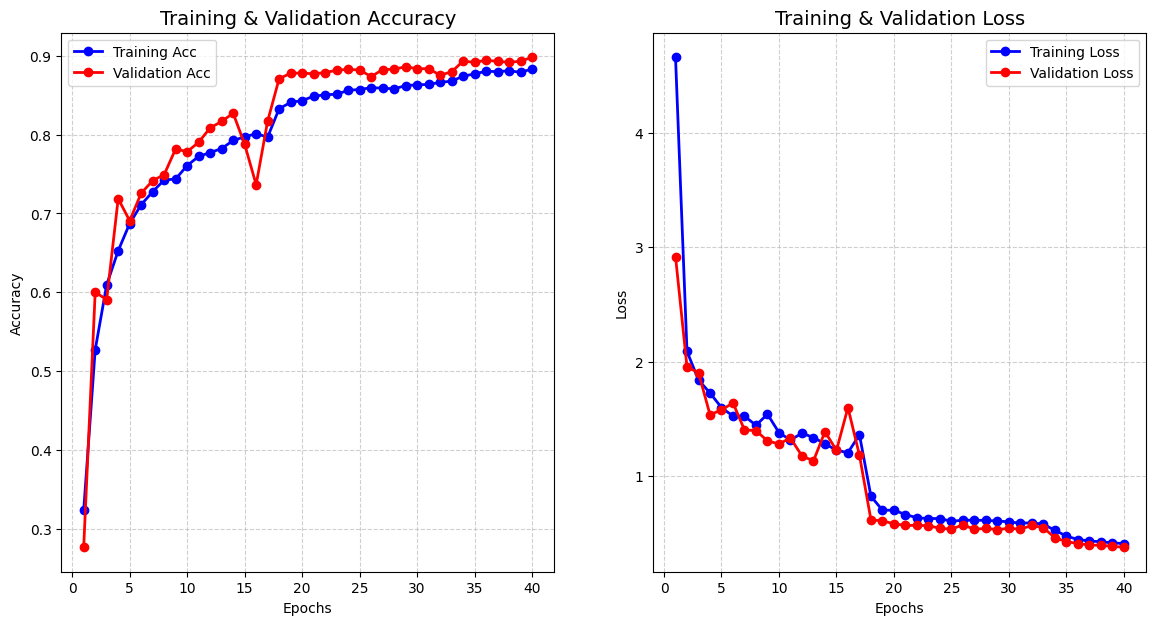


          BEST PERFORMANCE          
TRAINING:
  • Best Accuracy: 0.8831 (Epoch 40)
  • Lowest Loss:   0.4098 (Epoch 40)
----------------------------------------
VALIDATION:
  • Best Accuracy: 0.8980 (Epoch 40)
  • Lowest Loss:   0.3788 (Epoch 40)



In [4]:
phase2_history_path = '../models/phase2_history.pkl'

if os.path.exists(phase2_history_path):
    print(f"Loading Phase 2 training history from {phase2_history_path}...")
    
    with open(phase2_history_path, 'rb') as f:
        phase2_history = pickle.load(f)
    
    print("Phase 2 History loaded successfully.")
    print(f"Metrics available: {list(phase2_history.keys())}")
else:
    print(f"Error: File not found at {phase2_history_path}")

if 'phase2_history' in locals():
    print("Plotting Phase 2 results...")
    plot_history(phase2_history)
else:
    print("Phase 2 history data is not loaded yet.")

### 2. Deep Analysis of Phase 2 Results

The graphs generated in this phase reveal a highly successful training session with distinct behavioral patterns:

* **The "Learning Rate Step" (Epoch 17-18):**
    * There is a visible, sharp drop in Loss and a simultaneous spike in Accuracy around Epoch 17.
    * **Cause:** This confirms that the `ReduceLROnPlateau` callback (defined in `train.py`) successfully triggered. When the validation loss stopped improving, the system reduced the learning rate (likely by a factor of 0.2), allowing the model to descend into a deeper, more optimal minimum.

* **Metric Peaks:**
    * **Training Accuracy:** Peaked at **88.31%** (Epoch 40).
    * **Validation Accuracy:** Peaked at **89.80%** (Epoch 40).

* **Loss Reduction:** The Validation Loss dropped significantly to **0.3788**, indicating high confidence in the predictions.

### 3. Comparative Analysis: Baseline (Phase 1) vs. Final Model (Phase 2)

Comparing the initial results with the final results demonstrates the impact of the architectural improvements (deeper layers, L2 regularization, and increased Dropout).

| Metric | Baseline Model (Phase 1) | Final Model (Phase 2) | Improvement |
| :--- | :--- | :--- | :--- |
| **Best Val Accuracy** | 81.12% | **89.80%** | **+8.68%** |
| **Best Val Loss** | 0.5252 | **0.3788** | **-0.1464 (Better)** |
| **Stability** | High volatility (spiky curves) | Smoother convergence, esp. after Epoch 18 | **High Stability** |
| **Overfitting Risk** | Low (Val > Train) | Low (Val > Train) | **Maintained Generalization** |

**Critical Insight:** The Baseline model plateaued around 81%. The Final Model broke through this ceiling. The addition of the extra Convolutional block (256 filters) and the Dense layer (512 units) allowed the network to learn the subtle differences between "Neutral," "Sad," and "Surprise," which were the main sources of error in Phase 1.

# PROJECT CONCLUSION: SUCCESSFUL OPTIMIZATION

The transition from Phase 1 to Phase 2 has resulted in a robust, high-performance Facial Expression Recognition system.

1. **Resolved Underfitting:** The increased model complexity (5.8M parameters) successfully captured features that the shallower baseline missed.

2. **Strategic Convergence:** The implementation of `ReduceLROnPlateau` was the turning point, squeezing out nearly 90% accuracy in the final epochs.

3. **Deployment Ready:** With an accuracy of ~90% and a stable loss function, this model is now ready for deployment and real-world inference testing.